In [3]:
import tensorflow as tf

import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)

No GPU was detected. Neural nets can be very slow without a GPU.


ANIMACION

In [53]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            print("Steps: " + str(step))
            break
    env.close()
    return plot_animation(frames)



HARDCODED POLICY

In [54]:
#if the angle is negative means that the pole is leaning to the left, so we should push the cart to the left and viceversa
def basic_policy(obs):
    angle = obs[2] #angle is the third element of the observation and we store it in the variable angle
    return 0 if angle < 0 else 1

totals = [] #we will store the rewards of each episode in this list
for episode in range(500): #in this case we are going to run 500 episodes
    episode_rewards = 0 #we will store the rewards of each episode in this variable
    obs, info = env.reset(seed=episode) #we reset the environment for each episode
    for step in range(200): #we are going to run 200 steps for each episode
        action = basic_policy(obs) #we get the action from the basic_policy function
        obs, reward, done, truncated, info = env.step(action) #we send the action to the environment
        episode_rewards += reward #we add the reward to the episode_rewards variable
        if done or truncated:#if the episode is done or the pole is truncated, we break the loop
            break

    totals.append(episode_rewards) #we append the episode_rewards to the totals list
    
import numpy as np
np.mean(totals), np.std(totals), min(totals), max(totals) #for debugging the rewards
#show_one_episode(basic_policy)

(41.698, 8.389445512070509, 24.0, 63.0)

NEURAL NETWORK

In [55]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

#a model  that has 5 neurons in the first layer and 1 neuron in the second layer
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"), # layer with 5 neurons, using the ReLU activation function
    tf.keras.layers.Dense(1, activation="sigmoid"), # layer with 1 neuron, using the sigmoid activation function
])
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs): #the policy function takes an observation as input and returns the action to be taken
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0] # we use the model to predict the probability of the action 0 (left)
    return int(np.random.rand() > left_proba) #we return 1 if the random number is greater than the probability of the action 0

np.random.seed(42)


totals = [] #we will store the rewards of each episode in this list
for episode in range(10): #in this case we are going to run 500 episodes
    episode_rewards = 0 #we will store the rewards of each episode in this variable
    obs, info = env.reset(seed=episode) #we reset the environment for each episode
    for step in range(200): #we are going to run 200 steps for each episode
        action = pg_policy(obs) #we get the action from the pg_policy function
        obs, reward, done, truncated, info = env.step(action) #we send the action to the environment
        episode_rewards += reward #we add the reward to the episode_rewards variable
        if done or truncated:#if the episode is done or the pole is truncated, we break the loop
            break

    totals.append(episode_rewards) #we append the episode_rewards to the totals list
np.mean(totals), np.std(totals), min(totals), max(totals) #for debugging the rewards
#show_one_episode(pg_policy)

(28.4, 17.118411141224527, 12.0, 62.0)

GRADIENT

In [7]:
def play_one_step(env, obs, model, loss_fn): #function of one step
    with tf.GradientTape() as tape: #we use the gradient tape to record the operations
        left_proba = model(obs[np.newaxis]) #we use the model to predict the probability of the action 0 (left)
        action = (tf.random.uniform([1, 1]) > left_proba) #we use a random number to decide the action
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) #we create the target probability by the theorem of the probability of the complement
        loss = tf.reduce_mean(loss_fn(y_target, left_proba)) #we calculate the loss by calculating the reduction of the mean of the loss function

    grads = tape.gradient(loss, model.trainable_variables) #we calculate the gradients
    obs, reward, done, truncated, info = env.step(int(action)) #we send the action to the environment
    return obs, reward, done, truncated, grads #we return the new observation

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn): #function to play multiple episodes
    #lists to store the rewards and the gradients
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes): #for each episode
        #lists to store the rewards and the gradients of the current episode
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps): #for each step
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn) #do the operations of the step
            #store the reward and the gradients
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated: #if the episode is done or the pole is truncated, we break the loop
                break
        #store the rewards and the gradients of the current episode
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor): #function to discount the rewards
    discounted = np.array(rewards) #we create an array for the discounted rewards
    for step in range(len(rewards) - 2, -1, -1): #for each step
        discounted[step] += discounted[step + 1] * discount_factor #we discount the reward multiplying it by the discount factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor): #function to discount and normalize the rewards
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards] # list of discounted rewards
    flat_rewards = np.concatenate(all_discounted_rewards) #we concatenate the discounted rewards
    reward_mean = flat_rewards.mean() #we calculate the mean of the discounted rewards
    reward_std = flat_rewards.std() #we calculate the standard deviation of the discounted rewards
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards] #we return the normalized discounted rewards

#parameters for the policy gradient algorithm
n_iterations = 100
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)
#the neural net model same as the previous one
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn) #calculate the rewards and the gradients of multiple episodes

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")
    #this part is were we call the function that discount and normalize the rewards
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)): #for each variable in the model
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)#calculate the mean of the gradients times the rewards
        all_mean_grads.append(mean_grads) #store the mean gradients

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))#apply the gradients to the model


Iteration: 100/100, mean rewards: 121.5

MARKOV CHAINS

In [19]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


MARKOV DECISION PROCESS

In [20]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

QVALUES ITERATION

In [22]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions
amma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

QLearning

No GPU was detected. Neural nets can be very slow without a GPU.


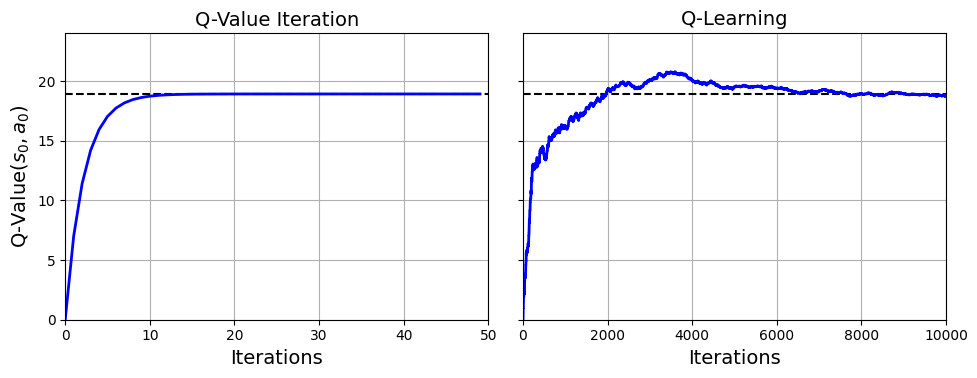

In [24]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1,2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    return np.random.choice(possible_actions[state])

# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

    alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

QLEARNING IN CART-POLE

In [56]:
#Import libraries
import gymnasium as gym
import numpy as np
import time
import matplotlib.animation
import matplotlib.pyplot as plt

#create the recources of the figure used in animation
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

#Method to save the figure
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

# Create the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.action_space.seed(42)
np.random.seed(42)
obs, info = env.reset(seed=42)

### Control Panel
n_episodes = 10000           # Number of total attempts        
reward_update_interval = 500    # (debug) print out total reward for every Nth iteration
learning_coeff = 500            # Large values -> Slower decay of willingness to learn/explore
exploration_coeff = 500         # You'll need to tweak both of these until you get good learning

# specify the number of bins for each state value
n_bins = (12,12,12,12)
# Discretize the observation space
lower_bounds = [env.observation_space.low[0], -0.25, 
                env.observation_space.low[2], -np.radians(50)]
upper_bounds = [env.observation_space.high[0], 0.25, 
                env.observation_space.high[2], np.radians(50)]

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


def discretizer(cart_position, cart_velocity, pole_angle, pole_velocity):
    def discretize_value(value, min_val, max_val, num_bins):
        # clips the value to the min and max
        value = max(min_val, min(value, max_val))
        # estimates the width of each bin
        bin_width = (max_val - min_val) / num_bins
        # finds the bin index
        bin_index = int((value - min_val) / bin_width)
        return min(bin_index, num_bins - 1)

    # Discretize each value
    cart_pos_index = discretize_value(cart_position, lower_bounds[0], upper_bounds[0], n_bins[0])
    cart_vel_index = discretize_value(cart_velocity, lower_bounds[1], upper_bounds[1], n_bins[1])
    pole_angle_index = discretize_value(pole_angle, lower_bounds[2], upper_bounds[2], n_bins[2])
    pole_vel_index = discretize_value(pole_velocity, lower_bounds[3], upper_bounds[3], n_bins[3])
    # returns the indexes of the bins
    return (cart_pos_index, cart_vel_index, pole_angle_index, pole_vel_index)

# Policy function returns the best action given the state
def greedy_policy(state):
    return np.argmax(Q_table[state])
# Exploration rate decay 
def exploration_rate(n, min_rate=0.01):
	return max(min_rate, min(1, 1.0 - np.log10((n + 1) / exploration_coeff)))
# Learning rate decay
def learning_rate(n, min_rate = 0.01):
    return max(min_rate, min(1.0, 1.0 - np.log10((n + 1) / learning_coeff)))
# function that stablishes the new q value giving the new state and the reward
def new_Q_value(reward, new_state, discount_factor = 1):
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value
 
# Q-table initialization (all zeros across all bins)
Q_table = np.zeros(n_bins + (env.action_space.n,))
 
# Start timer to record training time (training only, not video export)
totalTime = 0

rewards = []
# Game loop
for i in range(n_episodes):
    # Reset environment for fresh run
    observation, info = env.reset()
    #discretize variables
    current_state, terminated, truncated = discretizer(*observation), False, False
    #stores the last episode
    last_episode = i
    # Stat tracking
    total_reward_this_run = 0
 
    while not terminated and not truncated:
        # Start stopwatch for this iteration
        startTime = time.time()
 
        # Policy action
        action = greedy_policy(current_state)
        # Insert random action
        if np.random.random() < exploration_rate(i):
            action = env.action_space.sample()
        
        # Increment environment
        observation, reward, terminated, truncated, info = env.step(action)
        #frames.append(env.render())
        new_state = discretizer(*observation)
        # Update Q-table
        lr = learning_rate(i)
        learnt_value = new_Q_value(reward, new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value #the mos important part of the Q-learning algorithm
 
        # Update state
        current_state = new_state
 
        # Stats update
        total_reward_this_run += reward # max reward in this simulation is 1
 
        # Add training time for this iteration to accumulator
        endTime = time.time()
        totalTime += endTime - startTime
 
    #add reward of this run to the list
    rewards.append(total_reward_this_run)

    #break when the desire reward is reached and animate the last episode
    if np.mean(rewards) >= 200:
        frames = []
            # Reset environment for fresh run
        observation, info = env.reset()
            #discretize variables
        current_state, terminated, truncated = discretizer(*observation), False, False
        while not terminated and not truncated:
            # Start stopwatch for this iteration
            startTime = time.time()
            # Policy action
            action = greedy_policy(current_state)
            # exploration policy
            if np.random.random() < exploration_rate(i):
                action = env.action_space.sample()
            # Increment environment
            observation, reward, terminated, truncated, info = env.step(action)
            #frames.append(env.render())
            new_state = discretizer(*observation)
            # Update Q-table
            lr = learning_rate(i)
            learnt_value = new_Q_value(reward, new_state)
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
            # Update state
            current_state = new_state
            #append frames of the last episode
            frames.append(env.render())
        break

#time variables for time elapsed
trainM, trainS = map(int,divmod(totalTime, 60))
#information of the last iteration
print("\n")
print("Iteration:",last_episode)
print("Mean:",np.mean(rewards)," Min:", min(rewards)," Max:", max(rewards))
print(f"Total training time: {trainM}:{trainS:02}")
print("\n")

plot_animation(frames)




Iteration: 5089
Mean: 200.01689587426327  Min: 8.0  Max: 500.0
Total training time: 0:31


